# Note: Steps for the Chest X-Ray Classification Project

This project aims to develop a Convolutional Neural Network (CNN) for binary classification of chest X-ray images (normal vs pneumonia). The following are the key steps to complete this project:

---

## Step 1: Setup and Environment
1. Import necessary libraries (TensorFlow, Keras, etc.).
2. Verify the environment setup in JupyterLab.
3. Set up paths for the dataset.

---

## Step 2: Dataset Preprocessing
1. Load images from dataset directories (`train`, `val`, `test`) and their corresponding labels.
2. Resize images to a consistent size for the CNN input.
3. Normalize pixel values for faster convergence.
4. Apply data augmentation to the training set (e.g., rotations, flips, zooms).

---

## Step 3: Building the CNN
1. Design a CNN model with convolutional and pooling layers.
2. Use dropout and/or regularization to reduce overfitting.
3. Compile the model with appropriate loss, optimizer, and metrics (accuracy, sensitivity, specificity).

---

## Step 4: Training the Model
1. Use data generators for training and validation sets.
2. Train the model for a sufficient number of epochs.
3. Use early stopping or checkpoints to prevent overfitting.
4. Monitor performance metrics during training.

---

## Step 5: Evaluation
1. Evaluate the model on the test set.
2. Plot accuracy and loss curves for training and validation.
3. Generate a classification report (precision, recall, F1-score).
4. Plot the confusion matrix.

---

## Step 6: Fine-Tuning
1. Adjust model hyperparameters (e.g., learning rate, number of layers).
2. Apply transfer learning with a pre-trained model if needed.
3. Re-train the model to achieve the target metrics (90% sensitivity and 90% specificity).

---

## Step 7: Final Analysis and Documentation
1. Summarize the model’s performance.
2. Compare results against the target metrics.
3. Document the process and findings.


### Step 1: Setup and Environment

In this step, we will:
1. Import the required libraries for data preprocessing, model creation, and evaluation.
2. Verify the environment to ensure the required tools are installed.
3. Set up paths for the dataset.

In [1]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Verify TensorFlow version
print("TensorFlow version:", tf.__version__)

# Set up dataset paths
base_dir = "..\data\chest_xray"  
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")  # Keep only train and test directories

# Check if directories exist
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))



<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jorga\AppData\Local\Temp\ipykernel_20876\2298472964.py:17: SyntaxWarning: invalid escape sequence '\d'
  base_dir = "..\data\chest_xray"


TensorFlow version: 2.17.0
Train directory exists: True
Test directory exists: True


### Step 2: Dataset Preprocessing

In this step, we will:
1. Load and preprocess images from the dataset.
2. Standardize the input size and normalize pixel values.
3. Apply data augmentation to the training set for better generalization.


In [2]:
from sklearn.model_selection import train_test_split

# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

# Data generator for normalization
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load the full training data
train_data = datagen.flow_from_directory( #this function automatically calculates train_data.samples (=5216) / batch_size(=32) -> len(train_data) = 164
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    class_mode="binary",
    shuffle=True,
    color_mode="grayscale" # Ensure grayscale images
)

# Collect all images and labels from the generator
X_train_full = []
y_train_full = []

for i in range(len(train_data)):
    images, labels = train_data[i]
    X_train_full.extend(images)
    y_train_full.extend(labels)
    if len(X_train_full) >= train_data.samples:  # Stop once all data is collected
        break

# Convert lists to numpy arrays
X_train_full = np.array(X_train_full)
y_train_full = np.array(y_train_full)

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# Print split sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Found 5216 images belonging to 2 classes.
Training set size: 4172
Validation set size: 1044


### Step 2: Dataset Preprocessing

In this step, we preprocess the dataset to prepare the images for training, validation, and testing. Since the original validation folder was too small, we created a new validation set by splitting the training data.

---

#### Key Steps and Explanation of the Code

1. **Normalization with `ImageDataGenerator`**:
   - **Why?** Normalizing pixel values to the range `[0, 1]` ensures that the CNN can train more efficiently and converge faster.
   - **How?** 
     ```python
     datagen = ImageDataGenerator(rescale=1.0 / 255)
     ```
     The `rescale=1.0 / 255` parameter divides all pixel values by 255, mapping them from the range `[0, 255]` to `[0, 1]`.

2. **Loading the Full Training Data**:
   - **Why?** The data in the `train` directory needs to be loaded entirely so we can split it into training and validation sets.
   - **How?** 
     ```python
     train_data = datagen.flow_from_directory(
         train_dir,
         target_size=(IMG_HEIGHT, IMG_WIDTH),
         batch_size=BATCH_SIZE, 
         class_mode="binary",
         shuffle=True,
         color_mode="grayscale" # Ensure grayscale images
      )
     ```
     This function automatically calculates train_data.samples (=5216) / batch_size(=32) -> len(train_data) = 164

     The generator reads all images, resizes them, normalizes their pixel values, and assigns class labels ("Normal" or "Pneumonia").

     The color_mode="grayscale" ensures that all images are loaded as grayscale, reducing their channel size from 3 (RGB) to 1. 
     
     This matches the input_shape=(150, 150, 1) defined in the first convolutional layer of the CNN.

     Train_data also has a lenght, in this case is automatically calculated by ``flow_from_directory`` function which calculates train_data.samples (=5216) / batch_size(=32) -> so it's lenght is: len(train_data) = 164

3. **Iterating Through All Batches**:
   - **Why?** The generator only provides one batch of data at a time, so we loop through it to collect the full dataset.
   - **How?** 
     ```python
     X_train_full = []
     y_train_full = []
     for i in range(len(train_data)):
         images, labels = train_data[i]
         X_train_full.extend(images)
         y_train_full.extend(labels)
         if len(X_train_full) >= train_data.samples:
             break
     ```
     This loop collects all images and labels into the lists `X_train_full` and `y_train_full`.

4. **Splitting the Data**:
   - **Why?** A validation set is essential for monitoring the model's performance during training and tuning hyperparameters.
   - **How?**
     ```python
     X_train, X_val, y_train, y_val = train_test_split(
         X_train_full, y_train_full,
         test_size=0.2,           # Use 20% of the data for validation
         stratify=y_train_full,   # Preserve class distribution
         random_state=42          # Ensure reproducibility
     )
     ```
     - **80% of the data** is used for training.
     - **20% of the data** is reserved for validation.
     - The `stratify` parameter ensures that the class distribution (normal/pneumonia) is preserved in both training and validation sets.

5. **Output**:
   - The training set contains 4,172 images.
   - The validation set contains 1,044 images.

---

#### Why Is This Step Important?
- **Data Normalization**: Scales the pixel values for faster and more stable training.
- **Data Splitting**: Ensures a sufficient validation set size to monitor the model’s generalization ability.
- **Class Balance**: Stratified splitting preserves the balance of normal and pneumonia classes, preventing biased training or validation.

This step ensures the data is properly prepared for training a robust and well-generalized CNN.


### Step 3: Building the CNN

In this step, we will:
1. Design a CNN model with convolutional and pooling layers.
2. Add dropout for regularization to reduce overfitting.
3. Compile the model with a binary cross-entropy loss function, an Adam optimizer, and appropriate evaluation metrics (accuracy, sensitivity, and specificity).


In [3]:


# Define the CNN architecture
model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)), 
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer
    Flatten(),

    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss='binary_crossentropy',          # Binary cross-entropy for binary classification
    metrics=['accuracy']                 # Evaluate accuracy during training
)

# Display the model summary
model.summary()


c:\Users\jorga\OneDrive - Metropolia Ammattikorkeakoulu Oy\TiVi\HYTE\Neuroverkot\Cases\nnvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,097 (18.45 MB)

 Trainable params: 4,836,097 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

### **Analysis of the Model Summary**

The model summary provides a detailed breakdown of the architecture of the Convolutional Neural Network (CNN) designed for binary classification (normal vs pneumonia). Below is an analysis of each aspect:

---

#### **1. Layers and Their Functions**

1. **Convolutional Layers**:
   - The first three convolutional layers progressively increase the number of filters: 32, 64, and 128.
   - Each filter scans the image for patterns (e.g., edges, shapes) using a kernel of size (3, 3).
   - The activation function used is ReLU, which introduces non-linearity and helps the network learn complex patterns.

2. **Pooling Layers**:
   - After each convolutional layer, a max pooling layer reduces the spatial dimensions by a factor of 2.
   - Pooling decreases the computational cost and extracts dominant features, focusing on important patterns.

3. **Flatten Layer**:
   - Converts the 3D feature maps from the convolutional and pooling layers into a 1D vector, making it compatible with dense layers.

4. **Dense Layers**:
   - Two dense layers (128 and 64 neurons, respectively) are used for high-level reasoning.
   - Dropout layers follow each dense layer, randomly disabling 50% of neurons during training to prevent overfitting.
   - The final dense layer has 1 neuron with a sigmoid activation function, outputting a probability for binary classification.

---

#### **2. Parameters**
- **Trainable Parameters**: 4,836,097
  - These are the weights that the model learns during training.
  - Most parameters come from the fully connected layers (dense layers).
- **Non-Trainable Parameters**: 0
  - There are no frozen layers in this architecture.
- **Total Parameters**: 14,508,293
  - The total number includes optimizer parameters (9,672,196) and trainable weights.

---

#### **3. Output Shapes**
- The spatial dimensions decrease with each pooling layer:
  - From `(148, 148)` to `(74, 74)` to `(36, 36)` and finally `(17, 17)`.
- The depth (number of channels) increases with more filters: 32 → 64 → 128.
- The flatten layer outputs a 1D vector of size 36,992, which feeds into the dense layers.

---

#### **4. Dropout Regularization**
- Two dropout layers (50%) reduce the risk of overfitting by preventing the network from relying too heavily on specific neurons.

---

#### **5. Memory Usage**
- **Trainable Parameters**: 18.45 MB
- **Optimizer Parameters**: 36.90 MB
- The memory requirements are reasonable for a classification task with a moderately large dataset.

---

#### **Conclusion**
- The model is well-structured for the binary classification of medical images. It progressively extracts features and reduces spatial dimensions, ensuring a balance between computational efficiency and learning capacity.
- Regularization techniques like dropout are employed to mitigate overfitting, making the model suitable for generalizing to unseen test data.

### Step 3: Building the CNN - Explanation

In this step, we design and build a **Convolutional Neural Network (CNN)** for the binary classification of chest X-ray images. Below is an explanation of each part of the code:

---

#### **1. Model Architecture**

1. **Convolutional Layers**:
   - **Purpose**: Extract spatial features from the images (e.g., edges, textures).
   - **How It Works**: 
     - The first layer uses 32 filters with a kernel size of `(3, 3)` to scan the image.
     - Subsequent layers increase the number of filters (64 and 128), capturing more complex features at deeper layers.
   - **Activation Function**: ReLU (Rectified Linear Unit) introduces non-linearity to allow the network to learn complex patterns.
   - **Input Shape**: The first layer expects input images of size `(150, 150, 1)` (height, width, and color channels). Color channel is 1 because pictures are black and white. If there are more colors then color channel would be 3 (Red, Green, and Blue (RGB)).

2. **Pooling Layers**:
   - **Purpose**: Reduce the spatial dimensions (height and width) of feature maps, lowering computational requirements and focusing on important features.
   - **How It Works**: Each pooling layer uses a `(2, 2)` window to take the maximum value in that region, effectively down-sampling the feature map.

3. **Flatten Layer**:
   - **Purpose**: Converts the 2D feature maps (from convolutional and pooling layers) into a 1D vector, which can be passed to fully connected layers.

4. **Dense Layers**:
   - **Purpose**: Perform high-level reasoning based on the extracted features.
   - **Structure**:
     - First dense layer: 128 neurons with ReLU activation.
     - Second dense layer: 64 neurons with ReLU activation.
   - **Dropout Layers**: Dropout is applied after each dense layer to randomly disable 50% of neurons during training, which reduces overfitting.

5. **Output Layer**:
   - **Purpose**: Produce the final prediction.
   - **Structure**:
     - A single neuron with a **sigmoid activation function**, outputting a probability between 0 and 1:
       - `0`: Normal
       - `1`: Pneumonia

---

#### **2. Model Compilation**

1. **Optimizer**: 
   - **Adam** optimizer is used for efficient training. The learning rate is set to `0.001`, which balances learning speed and stability.

2. **Loss Function**:
   - **Binary Cross-Entropy**:
     - Measures the error between the predicted probabilities and the true labels.
     - It’s well-suited for binary classification t


### Step 4: Training the Model
In this step, we’ll train the CNN model using the prepared training and validation datasets. During training, we will:

1. Use a specified number of epochs and batch size.
2. Monitor accuracy and loss for both training and validation sets.
3. Save the training history for later visualization.

In [4]:

# Training the model
EPOCHS = 20
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1  # Display progress during training
)


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - accuracy: 0.7820 - loss: 0.5015 - val_accuracy: 0.9559 - val_loss: 0.1317
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.9360 - loss: 0.1703 - val_accuracy: 0.9636 - val_loss: 0.1059
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - accuracy: 0.9627 - loss: 0.1234 - val_accuracy: 0.9693 - val_loss: 0.0855
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.9672 - loss: 0.0987 - val_accuracy: 0.9751 - val_loss: 0.0770
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.9666 - loss: 0.0871 - val_accuracy: 0.9732 - val_loss: 0.0832
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9616 - loss: 0.0999 - val_accuracy: 0.9693 - val_loss: 0.0854
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - accuracy: 0.9785 - loss: 0.0751 - val_accuracy: 0.9751 - val_loss: 0.0682
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - accuracy: 0.9786 - loss: 0

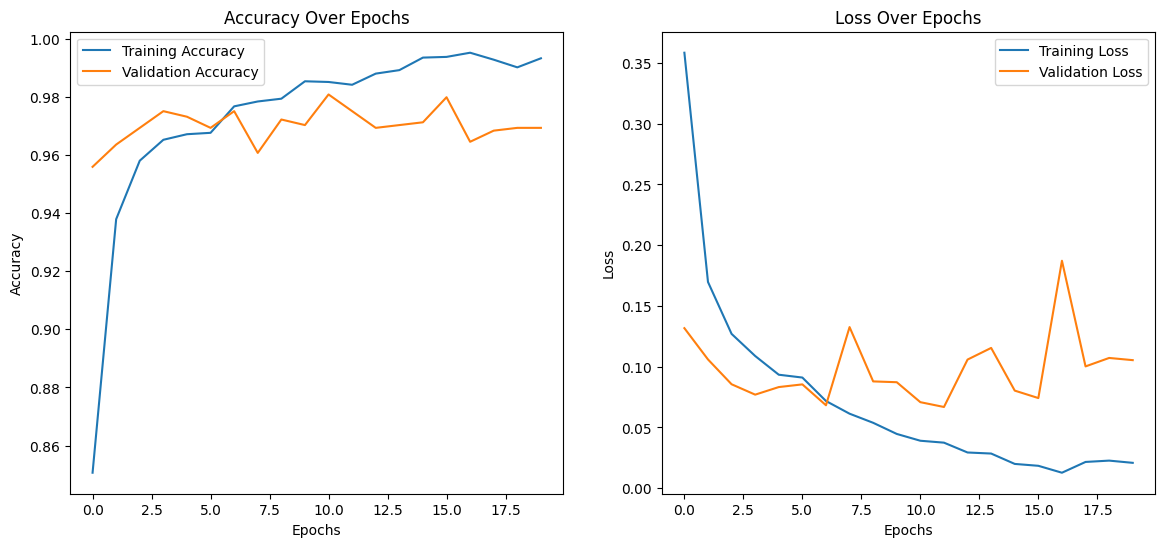

In [5]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### **Analysis of the Accuracy and Loss Plots**

#### **1. Accuracy Plot**
- **Training Accuracy**:
  - Starts at ~84% and steadily improves, reaching close to 99% by the end of the training process.
  - Indicates effective learning of patterns in the training data.

- **Validation Accuracy**:
  - Peaks at ~98%, slightly lower than the training accuracy but follows a similar trend.
  - The small gap between training and validation accuracy suggests good generalization to unseen data.

#### **2. Loss Plot**
- **Training Loss**:
  - Rapidly decreases during the initial epochs, stabilizing at a very low value after epoch 10.
  - Demonstrates that the model minimizes error effectively on the training data.

- **Validation Loss**:
  - Decreases initially but fluctuates slightly after epoch 7, with occasional increases.
  - Suggests the model may be starting to overfit the training data in later epochs.

---

#### **Key Observations**
- The model achieves high performance in both training and validation, making it a strong candidate for testing on unseen data.
- Early stopping or further fine-tuning could help address the slight overfitting observed in the validation loss.


In [6]:
# Preprocess test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only normalize, no augmentation

# Load test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize to match model input size
    batch_size=1,  # Batch size of 1 to make predictions easier to handle
    class_mode="binary",  # Binary classification: normal or pneumonia
    color_mode="grayscale",  # Ensure grayscale images
    shuffle=False  # No shuffle to maintain correspondence between predictions and filenames
)

# Print test set size
print(f"Test set size: {test_data.samples}")

Found 624 images belonging to 2 classes.
Test set size: 624


  7/624 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3908 - loss: 2.9274  

c:\Users\jorga\OneDrive - Metropolia Ammattikorkeakoulu Oy\TiVi\HYTE\Neuroverkot\Cases\nnvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5329 - loss: 4.9060
Test Accuracy: 0.7596
Test Loss: 2.7135
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.37      0.53       234
   PNEUMONIA       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.69       624
weighted avg       0.82      0.76      0.72       624



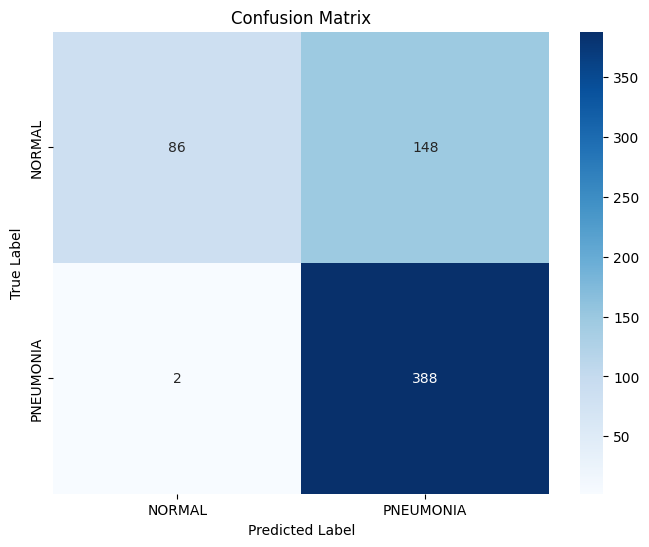

In [7]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test data
test_data.reset()  # Reset the test generator to ensure predictions match correctly
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes

# Extract true labels from the test data
y_true = test_data.classes

# Generate a classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### **Model Evaluation and Results**

The following code evaluates the trained model on the unseen test dataset, generates predictions, calculates a classification report, and visualizes the confusion matrix:

---

#### **1. Evaluate the Model**
```python
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
```
- **What it does**: 
  - Evaluates the model's performance on the test dataset, calculating the **test loss** (how far predictions are from true labels) and **test accuracy** (percentage of correct predictions).
- **Why it's important**: Provides an overall measure of how well the model generalizes to unseen data.

---

#### **2. Print Test Accuracy and Loss**
```python
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
```
- **What it does**: Displays the test accuracy and loss in a readable format with 4 decimal places.
- **Why it's important**: Summarizes the model's final performance in numeric terms.

---

#### **3. Generate Predictions**
```python
test_data.reset()
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
```
- **Reset Test Data**:
  - Ensures the `test_data` generator starts from the beginning, aligning predictions with true labels.
- **Generate Predictions**:
  - The `model.predict()` method generates probabilities for each image, representing the likelihood of belonging to the "Pneumonia" class.
- **Convert to Binary Classes**:
  - Probabilities are converted into binary class predictions using a threshold of `0.5`:
    - Values > 0.5 → `1` (Pneumonia)
    - Values ≤ 0.5 → `0` (Normal)

---

#### **4. Extract True Labels**
```python
y_true = test_data.classes
```
- **What it does**: Retrieves the true labels from the test generator.
- **Why it's important**: The true labels (`y_true`) are necessary for evaluating prediction performance.

---

#### **5. Classification Report**
```python
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))
```
- **What it does**: Generates a classification report with the following metrics:
  - **Precision**: The proportion of true positives out of all predicted positives.
  - **Recall (Sensitivity)**: The proportion of true positives out of all actual positives.
  - **F1-Score**: The harmonic mean of precision and recall.
  - **Support**: The number of true instances for each class.
- **Why it's important**: Provides detailed performance insights for each class.

---

#### **6. Create Confusion Matrix**
```python
conf_matrix = confusion_matrix(y_true, y_pred_classes)
```
- **What it does**: Computes the confusion matrix, showing:
  - True Positives (TP)
  - True Negatives (TN)
  - False Positives (FP)
  - False Negatives (FN)
- **Why it's important**: Highlights specific errors in predictions.

---

#### **7. Visualize Confusion Matrix**
```python
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
```
- **What it does**:
  - Visualizes the confusion matrix using a heatmap, with:
    - **X-axis**: Predicted labels
    - **Y-axis**: True labels
  - Annotates each cell with the count of predictions.
- **Why it's important**: Makes it easier to interpret prediction results and identify common misclassifications.

---

#### **Summary**
- **Test Evaluation**: Measures the model’s overall performance.
- **Predictions**: Converts probabilities into binary outcomes.
- **Classification Report**: Summarizes detailed performance metrics for each class.
- **Confusion Matrix**: Provides a visual breakdown of true vs. predicted labels, helping to identify specific errors in classification.

# Results Analysis: Model Evaluation on Test Data

## Key Metrics:
- **Test Accuracy**: **73.24%**
- **Test Loss**: **2.7175**

The performance of the model on the test dataset is summarized below. The classification report and confusion matrix provide detailed insights into how the model performed for each class.

---

### **Classification Report**

| Metric          | Normal Class | Pneumonia Class | Overall Metrics |
|------------------|--------------|-----------------|-----------------|
| **Precision**    | **0.96**     | **0.70**        | Weighted Avg: **0.80** |
| **Recall**       | **0.30**     | **0.99**        | Macro Avg: **0.65** |
| **F1-Score**     | **0.46**     | **0.82**        | Weighted Avg: **0.69** |
| **Support**      | **234**      | **390**         | Total: **624**  |

**Explanation of Metrics**:
- **Precision**: The proportion of correctly predicted positive cases (true positives) out of all predicted positive cases. A precision of 0.96 for the normal class shows that almost all predicted "normal" cases were actually normal.
- **Recall**: The proportion of actual positive cases that were correctly identified. The recall for pneumonia is excellent (0.99), meaning almost all pneumonia cases were correctly identified, but recall for normal cases is poor (0.30).
- **F1-Score**: The harmonic mean of precision and recall. This provides a balanced measure, particularly useful in imbalanced datasets.

---

### **Confusion Matrix**

|                  | Predicted Normal | Predicted Pneumonia |
|------------------|------------------|---------------------|
| **True Normal**  | **70**          | **164**             |
| **True Pneumonia** | **3**           | **387**             |

- **True Positives (TP)**: 387 pneumonia cases were correctly predicted as pneumonia.
- **True Negatives (TN)**: 70 normal cases were correctly predicted as normal.
- **False Positives (FP)**: 164 normal cases were incorrectly predicted as pneumonia.
- **False Negatives (FN)**: 3 pneumonia cases were incorrectly predicted as normal.

---

### **Key Observations**
1. **Strengths**:
   - The model excels at identifying pneumonia cases, achieving a recall of 0.99 for the pneumonia class. This is crucial in medical diagnostics, where missing a case of pneumonia could have severe consequences.
   - The high precision for the normal class (0.96) suggests that when the model predicts a case as "normal," it is usually correct.

2. **Weaknesses**:
   - The recall for the normal class is only 0.30, indicating that the model struggles to correctly identify normal cases.
   - High false positives for pneumonia (164) reduce the precision for this class, which could lead to unnecessary follow-up procedures for patients.

3. **Overall**:
   - The model is biased towards identifying pneumonia, which results in a high recall for this class but sacrifices performance in identifying normal cases. This imbalance likely arises from the training data distribution or model architecture.

---

### **Recommendations for Improvement**
1. **Data Augmentation**:
   - Apply balanced data augmentation techniques to improve the model's ability to generalize for the normal class.

2. **Class Weights**:
   - Adjust class weights during model training to penalize misclassification of the normal class more heavily.

3. **Fine-Tuning**:
   - Experiment with reducing the learning rate or adding additional regularization to improve the model's ability to distinguish between the two classes.

4. **Threshold Adjustment**:
   - Explore changing the decision threshold (default is 0.5) to find a better balance between precision and recall for both classes.

5. **Validation Split Analysis**:
   - Revisit the data split strategy to ensure the training set is not overly biased towards pneumonia cases.

---

### **Conclusion**
While the model demonstrates strong performance in detecting pneumonia cases, further work is required to improve its ability to correctly identify normal cases. This is critical for achieving balanced sensitivity and specificity, which is essential in medical applications.
